In [1]:
# !git clone https://github.com/pytorch/vision.git
# %cd vision
# !git checkout v0.3.0

# !cp references/detection/utils.py ../
# !cp references/detection/transforms.py ../
# !cp references/detection/coco_eval.py ../
# !cp references/detection/engine.py ../
# !cp references/detection/coco_utils.py ../
# %cd ..

In [2]:
import json, os, glob
from PIL import Image, ImageDraw
from math import atan2, cos, sin, sqrt, pi

from pycocotools.coco import COCO
import matplotlib.pyplot as plt

import numpy as np

import torch
import utils
import transforms as T
import copy

In [3]:
class_dict = {'NH':1}
dataDir_="TrainingMask/"
json_file_ = 'TrainingMask/annotationsCOCO.json'

dataDir="TrainingMask2/"
json_file = 'TrainingMask2/annotationsCOCO.json'

coco_labels= json.load(open(json_file))

coco = COCO(json_file)


coco_labels_= json.load(open(json_file_))

coco_ = COCO(json_file_)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


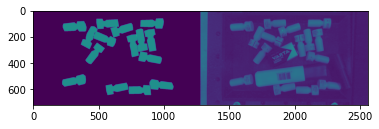

In [4]:
idx_=20
idx=coco.getImgIds()[idx_]
idx,[i['id'] for i in coco.imgToAnns[idx]]

img = Image.open(os.path.join(dataDir,coco.imgs[coco.getImgIds()[idx_]]['file_name'])).convert("RGB")
ids_=[i['id'] for i in coco.imgToAnns[idx]]
plt.figure()
plt.imshow(
np.hstack([np.sum([coco.annToMask(coco.anns[i]) for i in ids_],0)*255,np.array(img)[:,:,0]]))

In [5]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

class NHDataset(torch.utils.data.Dataset):
    def __init__(self, root,coco_, transforms=None):
        self.coco=copy.copy(coco_)
        for img_ in self.coco.imgToAnns:
            if not (img_==np.unique([i['image_id'] for i in self.coco.imgToAnns[img_]])[0]):
                raise OSError('image IDs dont match')

        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.img_ids=coco.getImgIds()

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, self.coco.imgs[self.img_ids[idx]]['file_name'])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask_ids=[i['id'] for i in self.coco.imgToAnns[self.img_ids[idx]]]
        num_objs=len(mask_ids)
        masks=[coco.annToMask(coco.anns[mask_id]) for mask_id in mask_ids]
        
        # get bounding box coordinates for each mask 
        # format before in COCO [xmin,ymin,width,height]
        #format after [xmin, ymin, xmax, ymax]
        boxes=[[i['bbox'][0],i['bbox'][1],i['bbox'][0]+i['bbox'][2],i['bbox'][1]+i['bbox'][3]] 
               for i in self.coco.imgToAnns[self.img_ids[idx]]]
        
        
        #get labels per mask
        labels=[i['category_id'] for i in self.coco.imgToAnns[self.img_ids[idx]]]
        
        # there is only one class
        
        #to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        image_id = torch.tensor(self.img_ids[idx])
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.img_ids)

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [7]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# use our dataset and defined transformations
dataset = NHDataset(dataDir,coco,get_transform(train=True))
dataset_test = NHDataset(dataDir_,coco_,get_transform(train=True))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
indices_ = torch.randperm(len(dataset_test)).tolist()

dataset = torch.utils.data.Subset(dataset, indices)
dataset_test = torch.utils.data.Subset(dataset_test, indices_)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)



In [9]:
# number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/home/aptech5829/Documents/osntVENV/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [ 0/12]  eta: 0:00:06  lr: 0.000459  loss: 7.1169 (7.1169)  loss_classifier: 0.7567 (0.7567)  loss_box_reg: 0.9547 (0.9547)  loss_mask: 5.3609 (5.3609)  loss_objectness: 0.0276 (0.0276)  loss_rpn_box_reg: 0.0170 (0.0170)  time: 0.5291  data: 0.2277  max mem: 2559
Epoch: [0]  [10/12]  eta: 0:00:00  lr: 0.005000  loss: 2.1205 (2.8748)  loss_classifier: 0.4724 (0.4793)  loss_box_reg: 0.7130 (0.7274)  loss_mask: 0.7583 (1.5739)  loss_objectness: 0.0435 (0.0585)  loss_rpn_box_reg: 0.0256 (0.0357)  time: 0.2447  data: 0.0243  max mem: 2901
Epoch: [0]  [11/12]  eta: 0:00:00  lr: 0.005000  loss: 1.9561 (2.7673)  loss_classifier: 0.3996 (0.4645)  loss_box_reg: 0.7130 (0.7324)  loss_mask: 0.7393 (1.4790)  loss_objectness: 0.0414 (0.0559)  loss_rpn_box_reg: 0.0256 (0.0355)  time: 0.2344  data: 0.0226  max mem: 2901
Epoch: [0] Total time: 0:00:02 (0.2378 s / it)
creating index...
index created!
Test:  [ 0/23]  eta: 0:00:08  model_time: 0.1314 (0.1314)  evaluator_time: 0.1234 (0.1234)  

Epoch: [3]  [ 0/12]  eta: 0:00:04  lr: 0.000500  loss: 0.6081 (0.6081)  loss_classifier: 0.0872 (0.0872)  loss_box_reg: 0.3316 (0.3316)  loss_mask: 0.1798 (0.1798)  loss_objectness: 0.0022 (0.0022)  loss_rpn_box_reg: 0.0074 (0.0074)  time: 0.3856  data: 0.1618  max mem: 2909
Epoch: [3]  [10/12]  eta: 0:00:00  lr: 0.000500  loss: 0.5604 (0.5235)  loss_classifier: 0.0761 (0.0748)  loss_box_reg: 0.2896 (0.2736)  loss_mask: 0.1745 (0.1654)  loss_objectness: 0.0022 (0.0028)  loss_rpn_box_reg: 0.0067 (0.0069)  time: 0.2355  data: 0.0187  max mem: 2909
Epoch: [3]  [11/12]  eta: 0:00:00  lr: 0.000500  loss: 0.5334 (0.5201)  loss_classifier: 0.0755 (0.0748)  loss_box_reg: 0.2662 (0.2722)  loss_mask: 0.1628 (0.1635)  loss_objectness: 0.0021 (0.0027)  loss_rpn_box_reg: 0.0067 (0.0069)  time: 0.2261  data: 0.0175  max mem: 2909
Epoch: [3] Total time: 0:00:02 (0.2287 s / it)
creating index...
index created!
Test:  [ 0/23]  eta: 0:00:03  model_time: 0.0444 (0.0444)  evaluator_time: 0.0054 (0.0054)  

Epoch: [6]  [ 0/12]  eta: 0:00:04  lr: 0.000050  loss: 0.3051 (0.3051)  loss_classifier: 0.0460 (0.0460)  loss_box_reg: 0.1168 (0.1168)  loss_mask: 0.1347 (0.1347)  loss_objectness: 0.0023 (0.0023)  loss_rpn_box_reg: 0.0052 (0.0052)  time: 0.4059  data: 0.1870  max mem: 2909
Epoch: [6]  [10/12]  eta: 0:00:00  lr: 0.000050  loss: 0.3747 (0.3821)  loss_classifier: 0.0673 (0.0632)  loss_box_reg: 0.1694 (0.1643)  loss_mask: 0.1459 (0.1478)  loss_objectness: 0.0015 (0.0019)  loss_rpn_box_reg: 0.0047 (0.0048)  time: 0.2379  data: 0.0206  max mem: 2909
Epoch: [6]  [11/12]  eta: 0:00:00  lr: 0.000050  loss: 0.3747 (0.3837)  loss_classifier: 0.0673 (0.0639)  loss_box_reg: 0.1694 (0.1656)  loss_mask: 0.1434 (0.1475)  loss_objectness: 0.0015 (0.0019)  loss_rpn_box_reg: 0.0046 (0.0048)  time: 0.2283  data: 0.0192  max mem: 2909
Epoch: [6] Total time: 0:00:02 (0.2317 s / it)
creating index...
index created!
Test:  [ 0/23]  eta: 0:00:03  model_time: 0.0452 (0.0452)  evaluator_time: 0.0056 (0.0056)  

Epoch: [9]  [ 0/12]  eta: 0:00:04  lr: 0.000005  loss: 0.2935 (0.2935)  loss_classifier: 0.0461 (0.0461)  loss_box_reg: 0.1123 (0.1123)  loss_mask: 0.1277 (0.1277)  loss_objectness: 0.0042 (0.0042)  loss_rpn_box_reg: 0.0032 (0.0032)  time: 0.3651  data: 0.1477  max mem: 2909
Epoch: [9]  [10/12]  eta: 0:00:00  lr: 0.000005  loss: 0.3693 (0.3788)  loss_classifier: 0.0721 (0.0671)  loss_box_reg: 0.1616 (0.1590)  loss_mask: 0.1357 (0.1454)  loss_objectness: 0.0014 (0.0026)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 0.2357  data: 0.0177  max mem: 2909
Epoch: [9]  [11/12]  eta: 0:00:00  lr: 0.000005  loss: 0.3693 (0.3793)  loss_classifier: 0.0665 (0.0663)  loss_box_reg: 0.1570 (0.1588)  loss_mask: 0.1357 (0.1469)  loss_objectness: 0.0014 (0.0024)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 0.2262  data: 0.0165  max mem: 2909
Epoch: [9] Total time: 0:00:02 (0.2297 s / it)
creating index...
index created!
Test:  [ 0/23]  eta: 0:00:03  model_time: 0.0437 (0.0437)  evaluator_time: 0.0056 (0.0056)  

In [10]:
torch.save(model, 'mask-rcnn-NH.pt')

In [11]:
# set to evaluation mode
model.eval()
CLASS_NAMES = ['__background__', 'NH']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [25]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')

def get_coloured_mask(mask):
    """
    random_colour_masks
      parameters:
        - image - predicted masks
      method:
        - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path,confidence,model,device):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    
    """
    if type(img_path) is not str:
        img=img_path
    else:
        img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def segment_instance(img_path,model,device confidence=0.5, rect_th=2, text_size=2, text_th=2):
    """
    segment_instance
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each mask is given random color
        - each mask is added to the image in the ration 1:0.8 with opencv
        - final output is displayed
    """
    masks, boxes, pred_cls = get_prediction(img_path, confidence,model,device)
    boxes=np.around(boxes).astype(int).tolist()
    if type(img_path) is not str:
        img=img_path
    else:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = get_coloured_mask(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [13]:
import sys
sys.path.append("..")
import osnt
from osnt import *

In [14]:
settings=open_settings_json(filename='../settings.json')
locals().update(settings)
# print(settings)

#init camera pipeline
pipeline = rs.pipeline()         
config = rs.config()            
config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)  
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

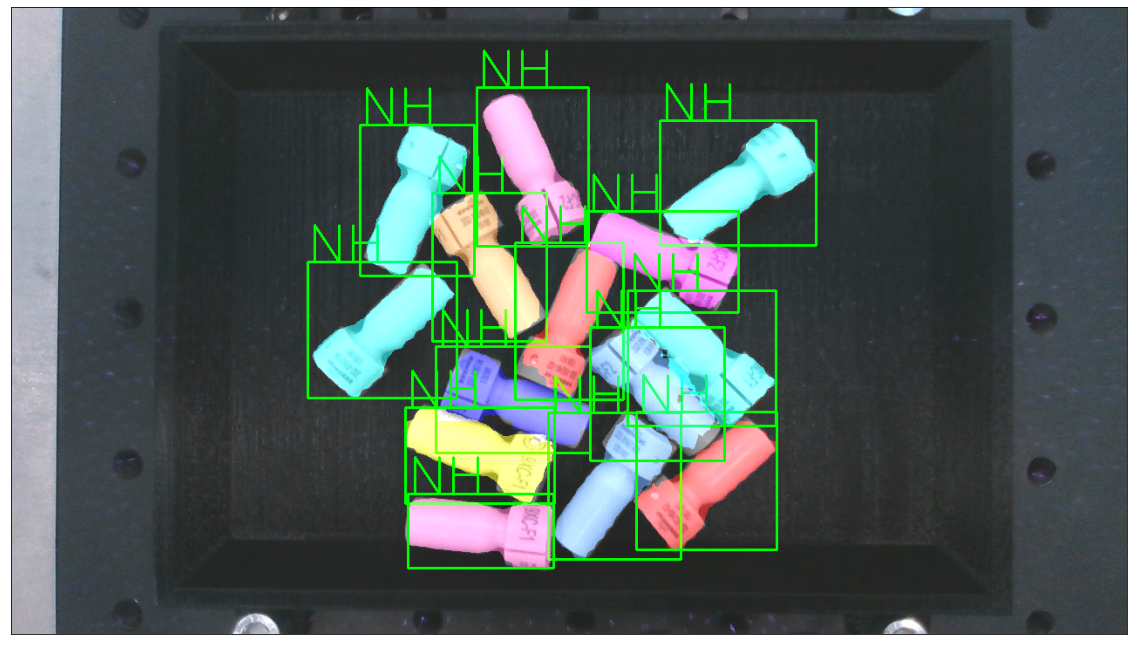

CPU times: user 584 ms, sys: 0 ns, total: 584 ms
Wall time: 1 s


In [48]:
%%time
bgr_img=take_picture(pipeline,config,exposure=exposure,sharpness=sharpness,contrast=contrast,
                       white_balance=white_balance,saturation=saturation,gain=gain,brightness=brightness)
b,g,r = cv2.split(bgr_img)       # get b,g,r
image = cv2.merge([r,g,b])

from_x,to_x,from_y,to_y=170,1130,40,690
bgr_img=bgr_img[from_y:to_y,from_x:to_x]



# plt.figure(figsize=[9,5])
# plt.imshow(image)

segment_instance(image, confidence=0.8)

In [24]:
masks.shape

(1, 1280)

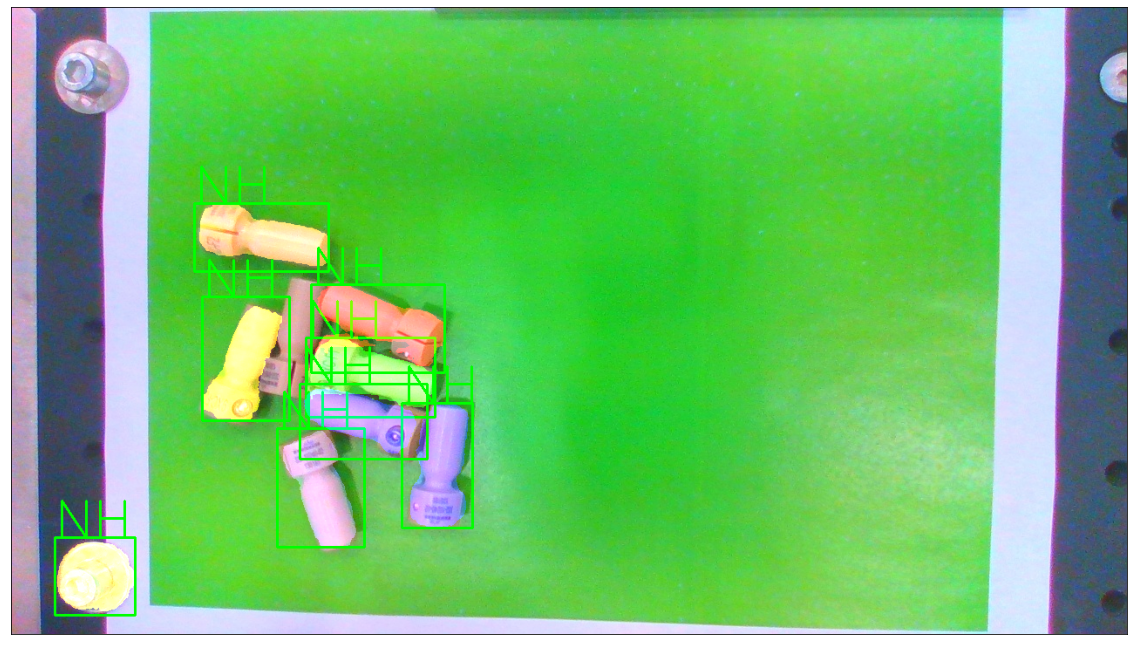

In [36]:
segment_instance('./test2.jpg', confidence=0.8)

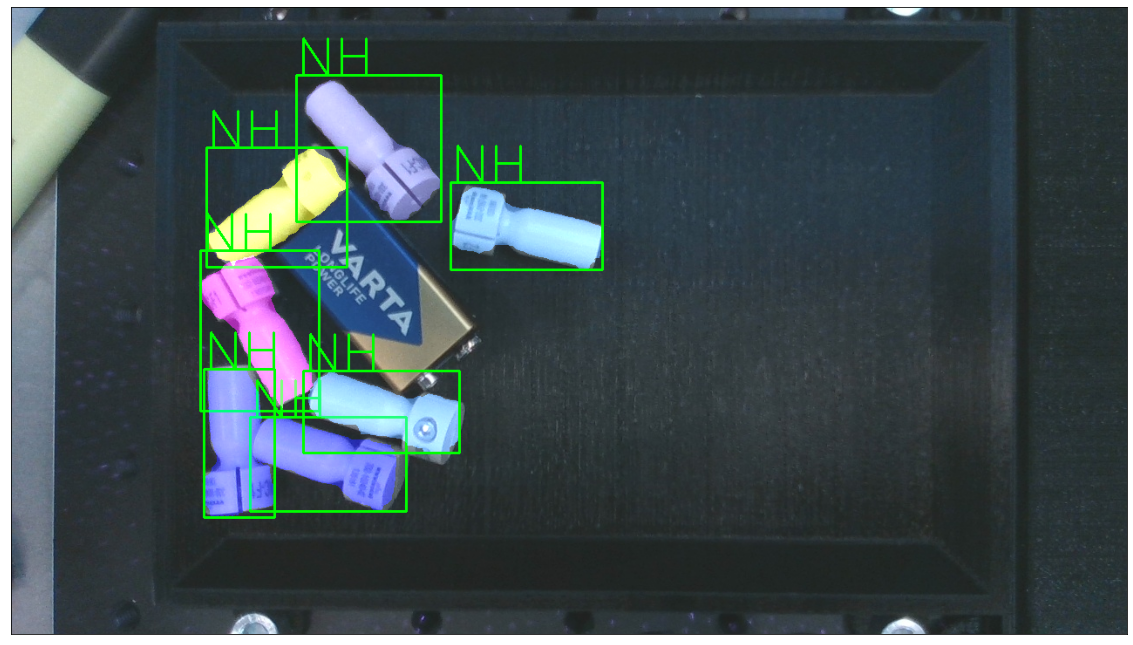

In [37]:
segment_instance(dataDir+'img36.jpg', confidence=0.8)